In [1]:
library(dplyr)
library(ggplot2)
library(tseries)
library(rugarch)
library(MASS)
library(latex2exp)

Warning message:
"pakiet 'dplyr' został zbudowany w wersji R 4.2.2"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.2.2"
Warning message:
"pakiet 'tseries' został zbudowany w wersji R 4.2.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"pakiet 'rugarch' został zbudowany w wersji R 4.2.3"
Ładowanie wymaganego pakietu: parallel


Dołączanie pakietu: 'rugarch'


Następujący obiekt został zakryty z 'package:stats':

    sigma


Warning message:
"pakiet 'MASS' został zbudowany w wersji R 4.2.3"

Dołączanie pakietu: 'MASS'


Następujący obiekt został zakryty z 'package:dplyr':

    select


Warning message:
"pakiet 'latex2exp' został zbudowany w wersji R 4.2.2"


In [2]:
emp_ACVF <- function(X,h){
    n <- length(X)
    xm <- mean(X)
    X1 <- X[1:(n-abs(h))]
    X2 <- X[(1+abs(h)):n]
    return(1/n*sum((X1-xm)*(X2-xm)))
}

In [3]:
emp_acorr <- function(X,h){
    Z <- emp_ACVF(X,h)
    Y <- emp_ACVF(X,0)
    return(Z/Y)
}

# Wstępne przedstawienie danych

In [69]:
Xt <- read.csv('wroclaw_notrend_noseason.csv')[,2:5]

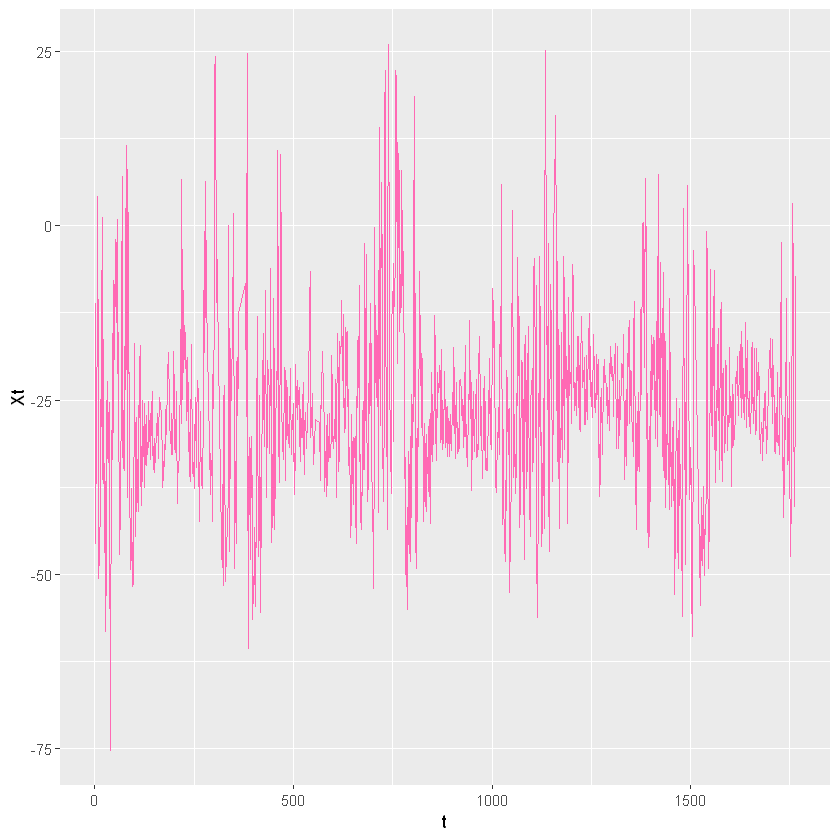

In [70]:
ggplot(Xt, aes(n, val_no_s2))+geom_line(col='hotpink')+ylab('Xt')+xlab('t')

In [71]:
h <- 1:1000
corr1 <- c()
for(i in h) corr1[i] <- emp_acorr(Xt$val_no_s2,i)
df_h <- data.frame(h,corr1)

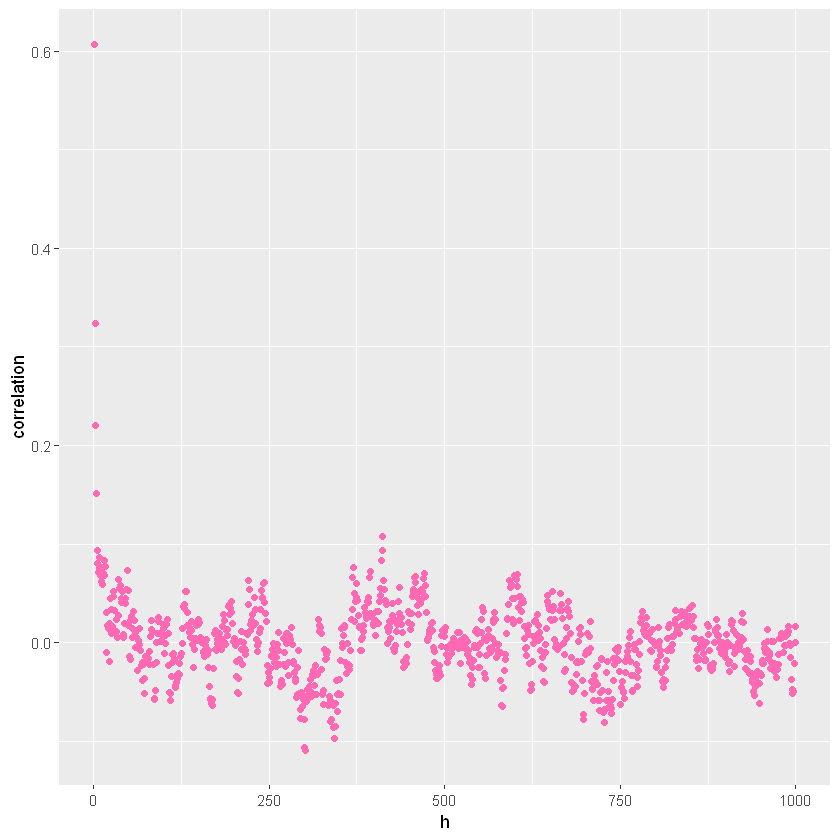

In [72]:
ggplot(df_h, aes(h,corr1))+geom_point(col='hotpink')+ylab('correlation')

# Dopasowanie rozkładu

In [73]:
fitdistr(Xt$val_no_s2, 'logistic')

    location        scale   
  -26.8877266     6.2711475 
 (  0.2652505) (  0.1315023)

## Test na poziomie istotnosci $\alpha=0.05$

In [74]:
ks.test(Xt$val_no_s2, 'plogis', loc=-26.89, scale=6.27)


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  Xt$val_no_s2
D = 0.032191, p-value = 0.06737
alternative hypothesis: two-sided


### P-value $= 0.06737 > 0.05$ zatem nie ma podstaw do odrzucenia hipotezy zerowej 

## Dopasowanie modelu ARMA(1,2)-GARCH(1,1)

https://quant.stackexchange.com/questions/4948/how-to-fit-armagarch-model-in-r

In [75]:
spec <- ugarchspec(variance.model = list(model = "sGARCH", 
                                         garchOrder = c(1, 1), 
                                         submodel = NULL, 
                                         external.regressors = NULL, 
                                         variance.targeting = FALSE), 

                   mean.model     = list(armaOrder = c(1, 2), 
                                         external.regressors = NULL, 
                                         distribution.model = "logis", 
                                         start.pars = list(), 
                                         fixed.pars = list()))

garch <- ugarchfit(spec = spec, data = Xt$val_no_s2, solver.control = list(trace=0))

Warning message:
"unidentified option(s) in mean.model:
 distribution.model start.pars fixed.pars"


In [76]:
garch@fit$coef

mu          ar1          ma1          ma2        omega       alpha1 
-26.23154107   0.67013009  -0.02328254  -0.12241391   0.65889895   0.10072098 
       beta1 
  0.89533134

## Przykładowa symulacja dopasowanego modelu

In [85]:
garch_sim <- ugarchsim(garch,n.sim=1636, startMethod='sample')

In [86]:
sp_sim <- garch_sim@simulation$seriesSim

In [87]:
Xt$simulated <- sp_sim

Saving 10 x 6.67 in image


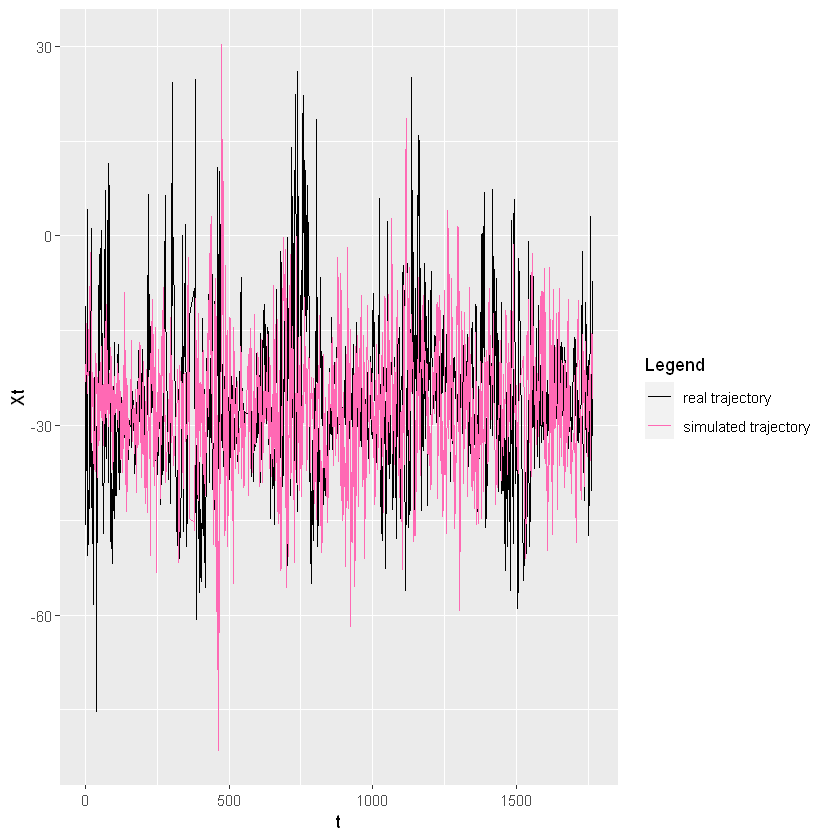

In [88]:
sim_traj_plot <- ggplot(Xt, aes(n))+geom_line(aes(y=val_no_s2, col='real trajectory'))+
    geom_line(aes(y=simulated, col='simulated trajectory'))+scale_color_manual(values=c('black', 'hotpink'))+
    guides(col=guide_legend(title="Legend")) + xlab('t') + ylab('Xt')
sim_traj_plot
ggsave('sim_traj_plot.jpg', sim_traj_plot, 'jpg', width=10)

# Linie kwantylowe

In [89]:
trajectories <- matrix(0,nrow=1000, ncol=1636)
for(i in 1:1000) trajectories[i,] <- ugarchsim(garch,n.sim=1636, startMethod='sample')@simulation$seriesSim

In [90]:
quant_5 <- c()
for(i in 1:1636) quant_5[i] <- quantile(trajectories[,i],0.05)
quant_95 <- c()
for(i in 1:1636) quant_95[i] <- quantile(trajectories[,i],0.95)
quant_10 <- c()
for(i in 1:1636) quant_10[i] <- quantile(trajectories[,i],0.1)
quant_90 <- c()
for(i in 1:1636) quant_90[i] <- quantile(trajectories[,i],0.9)
quant_20 <- c()
for(i in 1:1636) quant_20[i] <- quantile(trajectories[,i],0.2)
quant_80 <- c()
for(i in 1:1636) quant_80[i] <- quantile(trajectories[,i],0.8)
quant_30 <- c()
for(i in 1:1636) quant_30[i] <- quantile(trajectories[,i],0.3)
quant_70 <- c()
for(i in 1:1636) quant_70[i] <- quantile(trajectories[,i],0.7)
quant_40 <- c()
for(i in 1:1636) quant_40[i] <- quantile(trajectories[,i],0.4)
quant_60 <- c()
for(i in 1:1636) quant_60[i] <- quantile(trajectories[,i],0.6)

Saving 10 x 6.67 in image


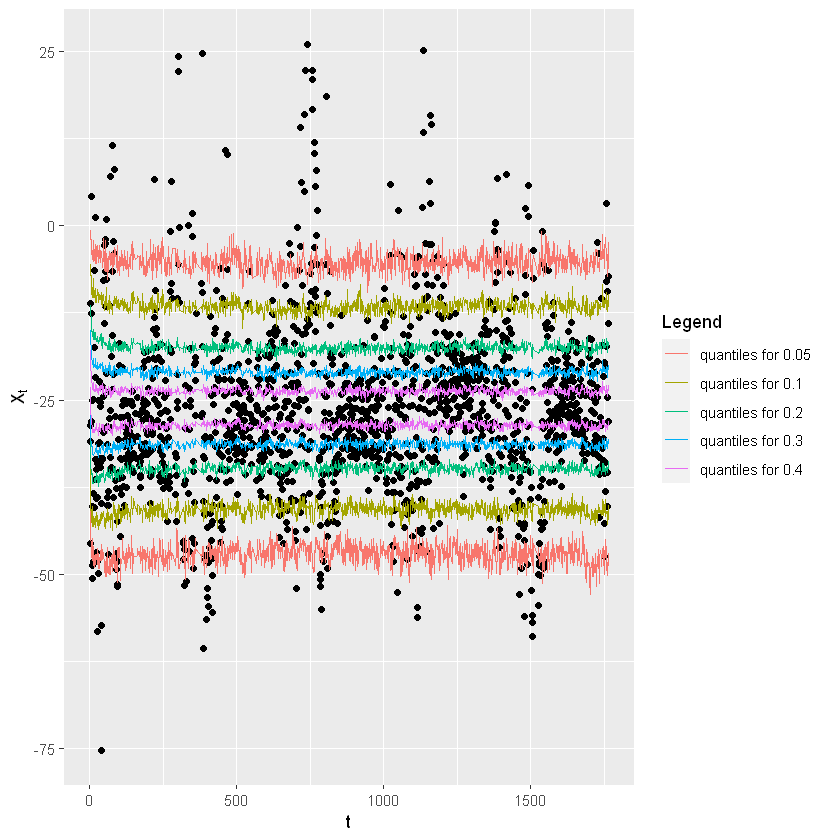

In [91]:
quantile_lines <- ggplot(Xt, aes(n,val_no_s2))+
    geom_point()+ylab(TeX('$X_t$'))+xlab('t')+
    geom_line(aes(y=quant_5,col='quantiles for 0.05'))+
    geom_line(aes(y=quant_95,col='quantiles for 0.05'))+
    geom_line(aes(y=quant_10,col='quantiles for 0.1'))+
    geom_line(aes(y=quant_90,col='quantiles for 0.1'))+
    geom_line(aes(y=quant_20,col='quantiles for 0.2'))+
    geom_line(aes(y=quant_80,col='quantiles for 0.2'))+
    geom_line(aes(y=quant_30,col='quantiles for 0.3'))+
    geom_line(aes(y=quant_70,col='quantiles for 0.3'))+
    geom_line(aes(y=quant_40,col='quantiles for 0.4'))+
    geom_line(aes(y=quant_60,col='quantiles for 0.4'))+
    guides(col=guide_legend(title="Legend"))
quantile_lines
ggsave('quantile_lines.jpg', quantile_lines, 'jpg', width=10)

In [92]:
prob5 <- 0
prob10 <- 0
prob20 <- 0
prob30 <- 0
prob40 <- 0
for(i in 1:1636){
    X <- Xt$val_no_s2[i]
    if(X>quant_5[i] & X<quant_95[i]) prob5 <- prob5+1
    if(X>quant_10[i] & X<quant_90[i]) prob10 <- prob10+1
    if(X>quant_20[i] & X<quant_80[i]) prob20 <- prob20+1
    if(X>quant_30[i] & X<quant_70[i]) prob30 <- prob30+1
    if(X>quant_40[i] & X<quant_60[i]) prob40 <- prob40+1
}

In [93]:
probs <- data.frame(prob5,prob10,prob20,prob30,prob40)
probs/1636

prob5,prob10,prob20,prob30,prob40
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9162592,0.8141809,0.6430318,0.4193154,0.2017115


# Prognoza i porównanie z danymi testowymi

In [94]:
Xt_test <- read.csv('wroclaw_notrend_noseason_test.csv')[,2:6]

In [95]:
trajectories2 <- matrix(0,nrow=1000, ncol=61)
for(i in 1:1000) trajectories2[i,] <- ugarchsim(garch,n.sim=1697, startMethod='sample')@simulation$seriesSim[1637:1697,]

In [96]:
quant_5_2 <- c()
for(i in 1:61) quant_5_2[i] <- quantile(trajectories2[,i],0.05)
quant_95_2 <- c()
for(i in 1:61) quant_95_2[i] <- quantile(trajectories2[,i],0.95)

Saving 10 x 6.67 in image


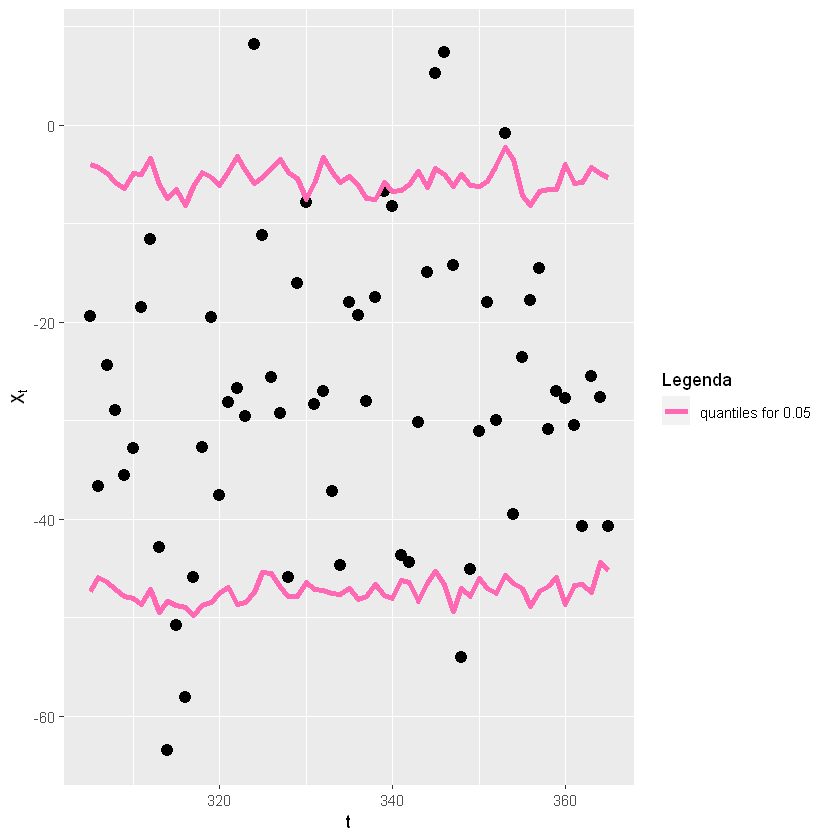

In [97]:
predict_lines <- ggplot(Xt_test, aes(n,val_no_s2))+
    geom_point(cex=3)+ylab(TeX('$X_t$'))+xlab('t')+
    geom_line(aes(y=quant_5_2,col='quantiles for 0.05'),linewidth=1.5)+
    geom_line(aes(y=quant_95_2,col='quantiles for 0.05'),linewidth=1.5)+
    scale_color_manual(values=c('hotpink'))+
    guides(col=guide_legend(title="Legenda"))
predict_lines
ggsave('predict_lines.jpg', predict_lines, 'jpg', width=10)

In [104]:
Xt_all <- read.csv('all_notrend_noseason.csv')[,2:7]

In [105]:
trajectories3 <- matrix(0,nrow=1000, ncol=2384)
for(i in 1:1000) trajectories3[i,] <- ugarchsim(garch,n.sim=2384, startMethod='sample')@simulation$seriesSim

In [116]:
quant_5_3 <- c()
for(i in 1:2384) quant_5_3[i] <- quantile(trajectories3[,i],0.05)
quant_95_3 <- c()
for(i in 1:2384) quant_95_3[i] <- quantile(trajectories3[,i],0.95)
quant_10_3 <- c()
for(i in 1:2384) quant_10_3[i] <- quantile(trajectories3[,i],0.1)
quant_90_3 <- c()
for(i in 1:2384) quant_90_3[i] <- quantile(trajectories3[,i],0.9)

Saving 10 x 6.67 in image


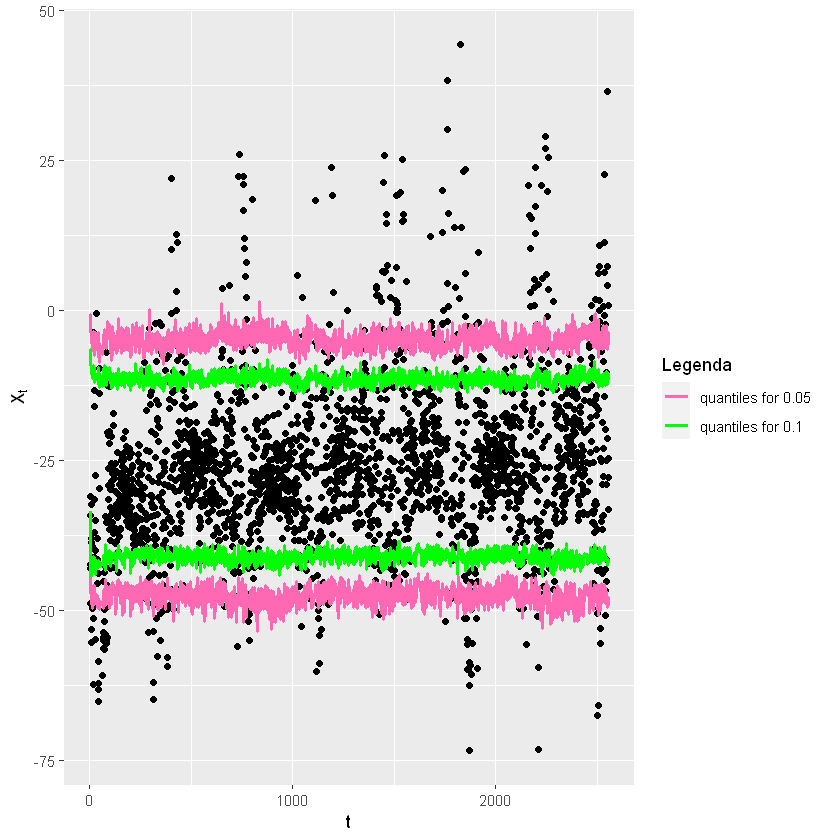

In [120]:
predict_lines_all <- ggplot(Xt_all, aes(n,val_no_s2))+
    geom_point()+ylab(TeX('$X_t$'))+xlab('t')+
    geom_line(aes(y=quant_5_3,col='quantiles for 0.05'),linewidth=1)+
    geom_line(aes(y=quant_95_3,col='quantiles for 0.05'),linewidth=1)+
    geom_line(aes(y=quant_10_3,col='quantiles for 0.1'),linewidth=1)+
    geom_line(aes(y=quant_90_3,col='quantiles for 0.1'),linewidth=1)+
    scale_color_manual(values=c('hotpink', 'green'))+
    guides(col=guide_legend(title="Legenda"))
predict_lines_all
ggsave('predict_lines_all.jpg', predict_lines_all, 'jpg', width=10)

In [118]:
prob5_2 <- 0
prob10_2 <- 0
for(i in 1:2384){
    X <- Xt_all$val_no_s2[i]
    if(X>quant_5_3[i] & X<quant_95_3[i]) prob5_2 <- prob5_2+1
    if(X>quant_10_3[i] & X<quant_90_3[i]) prob10_2 <- prob10_2+1
}

In [119]:
prob5_2/2384
prob10_2/2384

[1] 0.885906

[1] 0.778943